In [1]:
import theano
import theano.tensor as T
import lasagne as L

from theano.printing import Print as TPP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla M2090 (CNMeM is disabled, cuDNN not available)


In [2]:
%run lstm_optimizer.py

In [3]:
input_var = T.vector()

In [4]:
from theano.tensor.shared_randomstreams import RandomStreams
rng = RandomStreams(seed=42)

class QuadraticFunction:
    def __init__(self, theta=None, W=None, b=None):
        self.W = W or T.matrix('W')
        self.b = b or T.vector('b')
#        self.W = W or rng.normal(avg=0., std=1.0, size=(theta.shape[0], theta.shape[0]))
#        self.b = b or rng.normal(avg=0., std=1.0, size=(theta.shape[0],))
    
        self.theta = theta or T.vector('theta')
        
        self.func = ((T.dot(self.W, self.theta) - self.b)**2).sum() / 100.0
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.W, self.b]
        
class RosenbrockFunction:
    def __init__(self, theta=None, a=None, b=None):
        self.a = a or T.scalar('a')
        self.b = b or T.scalar('b')
        self.theta = theta or T.vector('theta')
        
        self.func =  ( (self.a - self.theta[0])**2 + self.b * (theta[1] - theta[0]**2)**2 ) / 1000.0
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.a, self.b]

In [5]:
def build_net(func, n_steps, n_hidden=20):
    l_input = L.layers.InputLayer(shape=(None,), input_var=input_var)
    l_optim = LSTMOptimizerLayer(l_input, num_units=n_hidden, n_steps=n_steps, function=func)
    
    return l_optim

In [6]:
# W = T.matrix()
# b = T.vector()
    
# func = lambda theta: QuadraticFunction(theta, W, b).func

a = T.scalar()
b = T.scalar()
    
func = lambda theta: RosenbrockFunction(theta, a, b).func

In [17]:
n_steps = T.iscalar() 
l_optim = build_net(func, n_steps, 600)

theta_history, loss_history = L.layers.get_output(l_optim)
loss = np.log(loss_history).sum()
#loss = loss_history.sum()

lr = theano.shared(np.array(0.001, dtype=np.float32))

params = L.layers.get_all_params(l_optim)
updates = L.updates.adam(loss, params, learning_rate=lr)

In [18]:
loss_fn = theano.function([input_var, n_steps, a, b], [theta_history, loss_history], allow_input_downcast=True)
train_fn = theano.function([input_var, n_steps, a, b], [theta_history, loss_history], updates=updates, allow_input_downcast=True)

In [19]:
def sgd_step(theta, lr):
    f = func(theta)
    g = theano.grad(f, theta)
    return theta - lr * g, f

sgd_lr = T.scalar()
sgd_thetas, sgd_losses = theano.scan(fn=sgd_step,
                                        outputs_info=[input_var, None],
                                                      non_sequences=sgd_lr,
                                                      n_steps=n_steps)[0]

sgd_fn = theano.function([input_var, n_steps, a, b, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)

In [20]:
def momentum_step(theta, old_grad, lr, mu):
    f = func(theta)
    g = theano.grad(f, theta)
    new_grad = mu * old_grad + g
    return theta - lr * g, f, new_grad

momentum_steps = T.iscalar()
momentum_mu = T.scalar()

momentum_thetas, momentum_losses, _ = theano.scan(fn=momentum_step,
                                                  outputs_info=[input_var, None, T.zeros_like(input_var)],
                                                  non_sequences=[sgd_lr, momentum_mu],
                                                  n_steps=n_steps)[0]

momentum_fn = theano.function([input_var, n_steps, a, b, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
        momentum_mu: np.cast['float32'](0.9),
    })

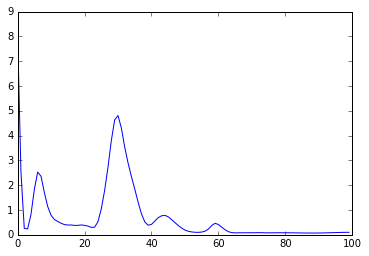

Epoch number 59
Time on epoch 59: 58.06231141090393
Average time on function 0.29031155705451966
Loss on 59: 44.613577055279166; 0.10036096721887589


In [24]:
from IPython import display
import time

for i in range(60):
    t = time.time()    

    training_loss_history = []
    for j in range(300):
        a_ = np.cast['float32'](np.random.rand() * 10)
        b_ = np.cast['float32'](np.random.rand() * 10)
        theta = np.cast['float32'](np.random.rand(2) * 10)
        
        theta_history, loss_history = train_fn(theta, 100, a_, b_)
        loss = sum(loss_history)
        training_loss_history.append(loss_history)
        
    display.clear_output(wait=True)
    plt.plot(np.mean(training_loss_history, axis=0))
    plt.show()
    print("Epoch number {}".format(i))
    t = time.time() - t
#    print("Time on epoch: {}".format(t))
    
    if i % 1 == 0:
        print("Time on epoch {}: {}".format(i, t))
        print("Average time on function {}".format(t / 200))
        print("Loss on {}: {}; {}".format(i, loss, np.mean(training_loss_history, axis=0)[-1]))
        
    lr.set_value((lr.get_value() * 0.9).astype(np.float32))

In [22]:
print(lr.get_value())
lr.set_value(0.0001)

0.0010000000474974513


In [25]:
print(loss_fn(np.zeros(2, dtype=np.float32), 100, a_, b_)[1][-1])

0.0111339


5.7476725578308105 7.303569793701172


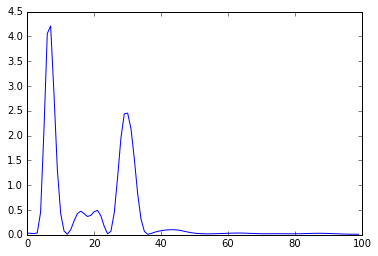

In [26]:
print(a_, b_)
plt.plot(loss_fn(np.zeros(2, dtype=np.float32), 100, a_, b_)[1])

In [27]:
train_history = momentum_fn(np.zeros(2, dtype=np.float32), 100, a_, b_, 0.01)[1]

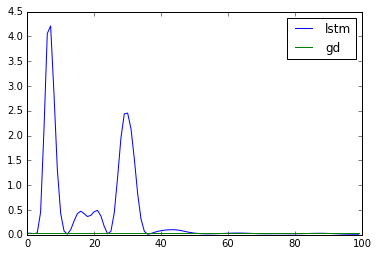

In [28]:
plt.plot(loss_fn(np.zeros(2, dtype=np.float32), 100, a_, b_)[1], label='lstm')
plt.plot(train_history, label='gd')
plt.legend();

In [114]:
from IPython import display

training_loss_history = []
training_loss_history_gd = []
training_loss_history_momentum = []

histories_gd = {lrate: [] for lrate in np.logspace(-3, 3, num=15)}
histories_momentum = {lrate: [] for lrate in np.logspace(-3, 3, num=15)}

for i in range(20):
    a_ = np.cast['float32'](np.random.rand() * 10)
    #a_ = 1.
    b_ = np.cast['float32'](np.random.rand() * 10)
    theta = np.zeros(2, dtype=np.float32)
    
    losses = loss_fn(theta, 500, a_, b_)[1]
    loss = sum(losses)
    training_loss_history.append(losses)
    
    for lrate in histories_gd.keys():
        train_history = sgd_fn(theta, 500, a_, b_, lrate)[1]
        histories_gd[lrate].append(np.array(train_history))

        train_history = momentum_fn(theta, 500, a_, b_, lrate)[1]
        histories_momentum[lrate].append(np.array(train_history))
    
    if i % 1 == 0:
        print("Loss on {}: {}".format(i, loss))

Loss on 0: 2.9111247515538707
Loss on 1: 17.07381407544017
Loss on 2: 1.7526739497407107
Loss on 3: 10.33272243104875
Loss on 4: 21.65262321010232
Loss on 5: 8.991109497845173
Loss on 6: 30.74949463829398
Loss on 7: 10.332116612233222
Loss on 8: 19.997820902615786
Loss on 9: 2.680956086725928
Loss on 10: 30.620708003640175
Loss on 11: 1.884066102214092
Loss on 12: 1.991310369005248
Loss on 13: 1.7847879416926844
Loss on 14: 1.7854118199020377
Loss on 15: 1.4443952080291638
Loss on 16: 1.5613313863250369
Loss on 17: 12.557606955990195
Loss on 18: 2.6911521385482047
Loss on 19: 26.21517002210021


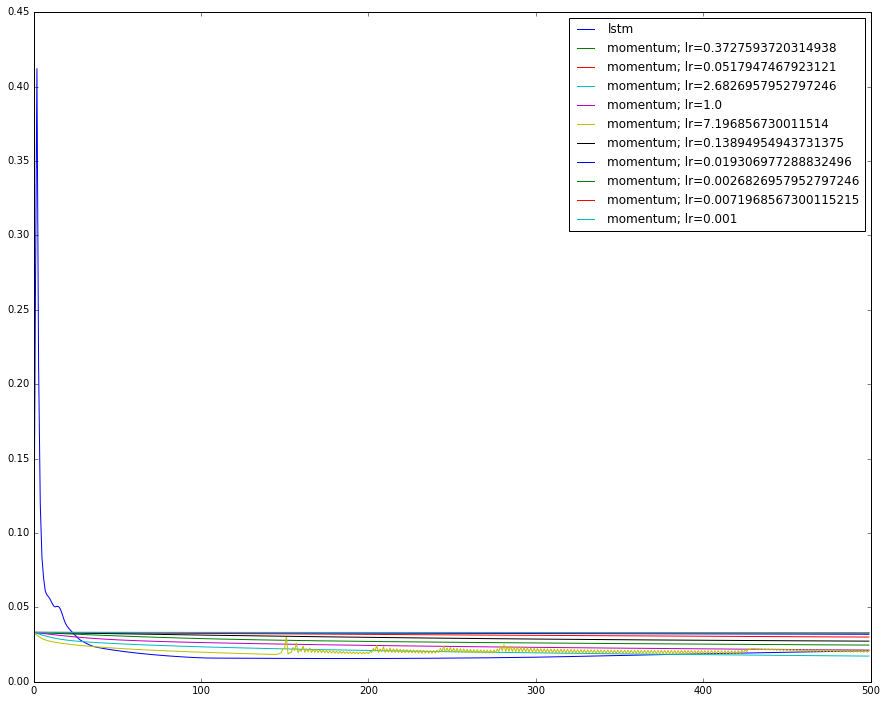

In [115]:
plt.figure(figsize=(15, 12))
plt.plot(np.mean(training_loss_history, axis=0), label='lstm')
# for lrate, history in histories_gd.items():
#     if lrate < 1e2:
#         plt.plot(np.mean(history, axis=0), label='gd; lr={}'.format(lrate))
for lrate, history in histories_momentum.items():
    if lrate < 1e1:
        plt.plot(np.mean(history, axis=0), label='momentum; lr={}'.format(lrate))
plt.legend();

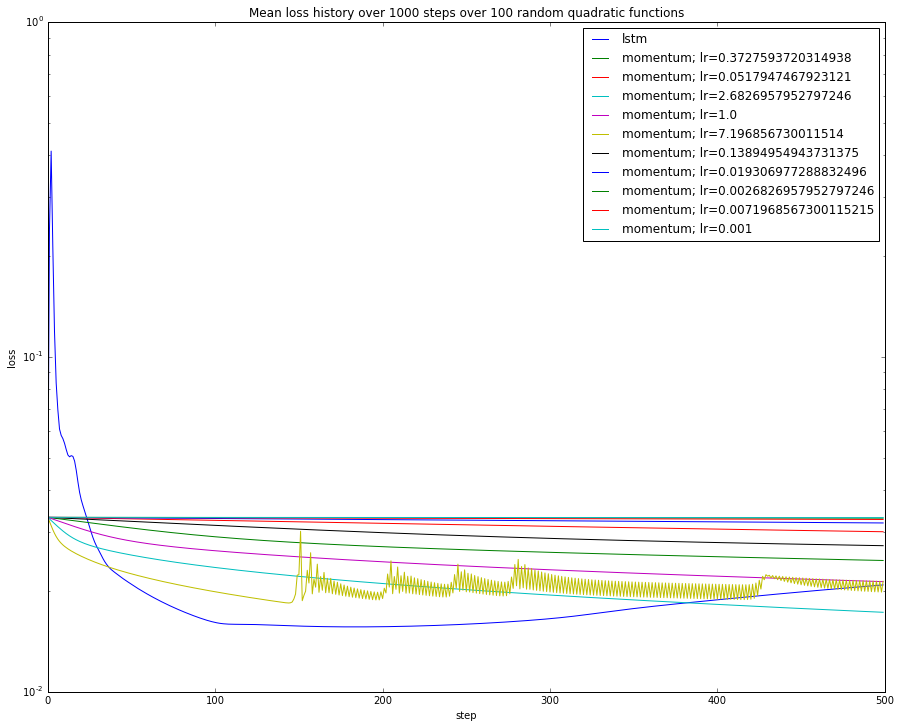

In [116]:
plt.figure(figsize=(15, 12))
plt.title('Mean loss history over 1000 steps over 100 random quadratic functions')
plt.xlabel('step')
plt.ylabel('loss')
plt.semilogy(np.mean(training_loss_history, axis=0), label='lstm')
# for lrate, history in histories_gd.items():
#     if lrate < 1e1:
#         plt.plot(np.log(np.mean(history, axis=0)), label='gd; lr={}'.format(lrate))
for lrate, history in histories_momentum.items():
    if lrate < 1e1:
        plt.semilogy(np.mean(history, axis=0), label='momentum; lr={}'.format(lrate))
plt.legend();

In [48]:
a_ = np.cast['float32'](np.random.rand() * 10)
b_ = np.cast['float32'](np.random.rand() * 10)

#a_ = np.cast['float32'](1.)
#b_ = np.cast['float32'](1.)
#theta = np.zeros(2, dtype=np.float32)
theta = np.cast['float32'](np.random.rand(2) * 10)

lstm_history, lstm_losses = loss_fn(theta, 200, a_, b_)
lstm_history = np.concatenate([theta.reshape(1, -1), lstm_history], axis=0)
lstm_loss = sum(lstm_losses)

pts_hst = {}

for lrate in np.logspace(-7, 1, 10):
#     if lrate >= 1e2:
#         continue
        
    sgd_points, sgd_losses = sgd_fn(theta, 200, a_, b_, lrate)
    sdg_points = [theta] + sgd_points
    
    pts_hst[lrate] = (sgd_points, sgd_losses)
    
    sgd_points, sgd_losses = momentum_fn(theta, 200, a_, b_, lrate)
    sdg_points = [theta] + sgd_points
    
    pts_hst[lrate] = (sgd_points, sgd_losses)

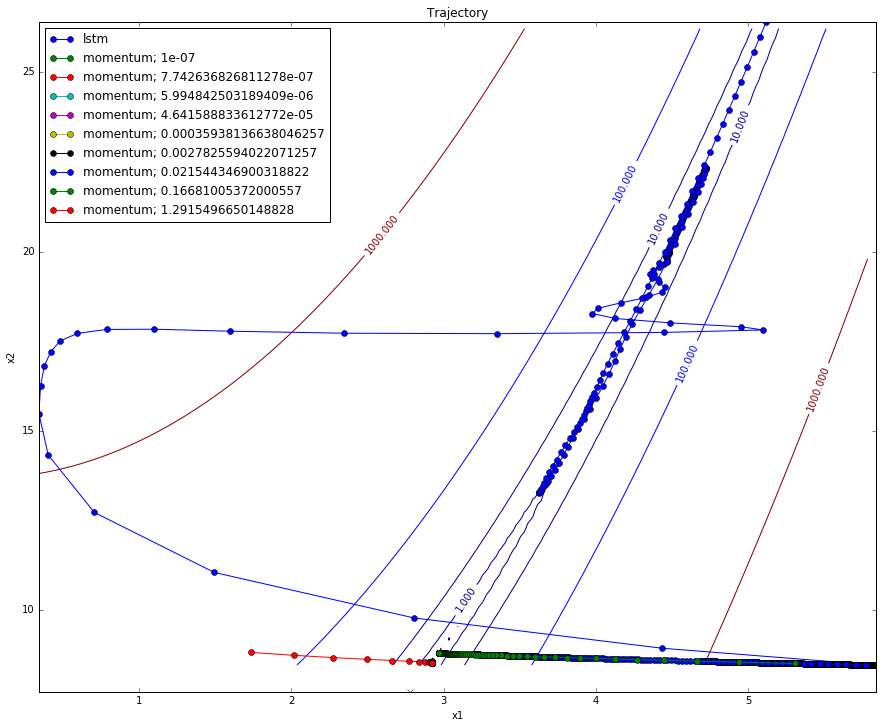

In [49]:
min_x = min(min(lstm_history.T[0]), 1.2*a_)
max_x = max(max(lstm_history.T[0]), 1.2*a_)
min_y = min(min(lstm_history.T[1]), 1.2*a_**2)
max_y = max(max(lstm_history.T[1]), 1.2*a_**2)

delta_x = (max_x - min_x) / 100.
delta_y = (max_y - min_y) / 100.

#x = np.arange(2 * min_x - (min_x + max_x) / 2, 2 * max_x - (min_x + max_x) / 2, delta_x)
#y = np.arange(2 * min_y - (min_y + max_y) / 2, 2 * max_y - (min_y + max_y) / 2, delta_y)
x = np.arange(min_x, max_x, delta_x)
y = np.arange(min_y, max_y, delta_y)
X, Y = np.meshgrid(x, y)

Z = (a_ - X)**2 + b_ * (Y - X**2)**2

plt.figure(figsize=(15, 12))
plt.title('Trajectory')

CS = plt.contour(X, Y, Z, levels=[1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3])
plt.clabel(CS, inline=1, fontsize=10)

plt.plot([a_], [a_**2], marker='x', color='k')

plt.xlabel('x1')
plt.ylabel('x2')
plt.plot(lstm_history.T[0], lstm_history.T[1], marker='o', label='lstm')
for lrate in np.logspace(-7, 1, 10):
    if lrate < 10:
        hist, _ = pts_hst[lrate]
        plt.plot(np.array(hist).T[0], np.array(hist).T[1], label='momentum; {}'.format(lrate), marker='o')
plt.legend(loc=2);

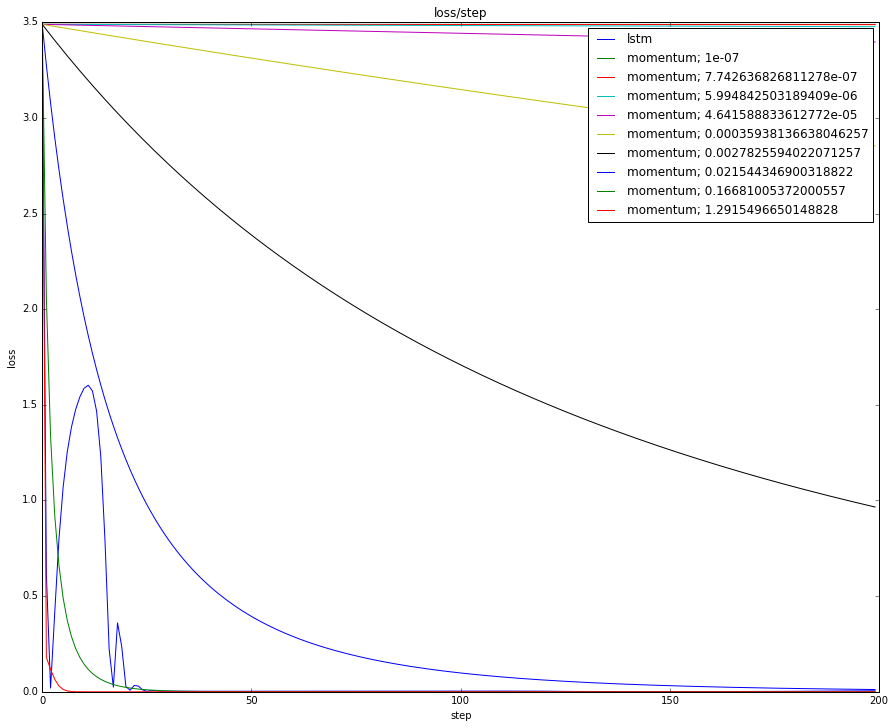

In [50]:
plt.figure(figsize=(15, 12))
plt.title('loss/step')
plt.xlabel('step')
plt.ylabel('loss')
plt.plot(lstm_losses, label='lstm')
for lrate in np.logspace(-7, 1, 10):
    if lrate < 10:
        _, lss = pts_hst[lrate]
        plt.plot(lss, label='momentum; {}'.format(lrate))
plt.legend();

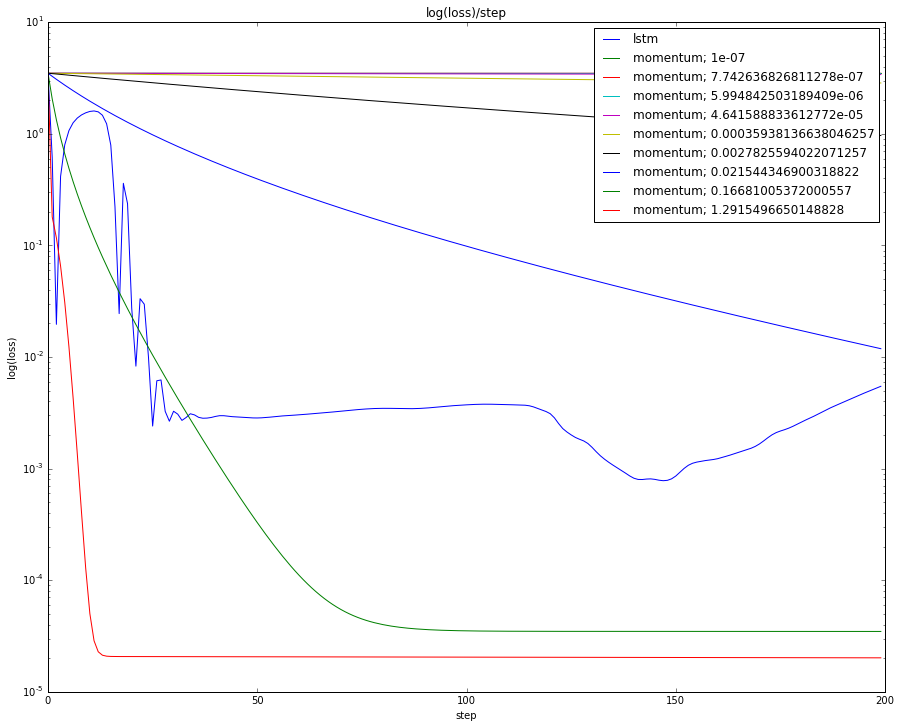

In [51]:
plt.figure(figsize=(15, 12))
plt.title('log(loss)/step')
plt.xlabel('step')
plt.ylabel('log(loss)')
plt.semilogy(lstm_losses, label='lstm')
for lrate in np.logspace(-7, 1, 10):
    if lrate < 10:
        _, lss = pts_hst[lrate]
        plt.semilogy(lss, label='momentum; {}'.format(lrate))
plt.legend();

In [43]:
print(a_, b_)

8.891878128051758 3.774688482284546
